In [1]:
#Imports
import os
import requests
import json 
from dotenv import load_dotenv
import tweepy
load_dotenv()
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt

In [2]:
#twitter API keys
twitter_api_key = os.getenv("TWITTER_API_KEY")
twitter_secret_key = os.getenv("TWITTER_SECRET_KEY")
twitter_access_token = os.getenv("TWITTER_ACCESS_TOKEN")
twitter_secret_token = os.getenv("TWITTER_SECRET_TOKEN")

In [3]:
#Authorize twitter use with account
def oAuth():
    try:
        auth = tweepy.OAuthHandler(twitter_api_key,twitter_secret_key)
        auth.set_access_token(twitter_access_token,twitter_secret_token)
        return auth
    except Exception as e:
        return None

oauth= oAuth()

#set twitter api object 
twitter_api = tweepy.API(oauth)

In [4]:
#Gather 2000 tweets - BTC
search_term = 'bitcoin' + '-filter:retweets'
#create a cursor object
#twitterapi.search_tweets has been most consistent with filtering retweets and getting hundreds of tweets without using twitter data website storage
tweets = tweepy.Cursor(twitter_api.search_tweets, q=search_term, tweet_mode = 'extended', lang = 'en').items(200)

In [7]:
#gather text from tweets
all_tweets = [tweet.full_text for tweet in tweets]

In [8]:
#create df for tweets
df = pd.DataFrame(all_tweets, columns=['Tweets'])
df.head()

,Tweets
0,Looks like CPI data is going to come better th...
1,#EURUSD ALL targets hit! 150 pips profit🎯\n\nJ...
2,Bitcoin is the future of money. Decentralizati...
3,@BitcoinMagazine @GovRonDeSantis Sounds like @...
4,"I can help you get back your hacked,locked Acc..."


In [9]:
#Function to try and clean up some of the noise in the tweets
def cleanTwt(twt):
    twt = re.sub('#bitcoin','bitcoin', twt)
    twt = re.sub('#Bitcoin','Bitcoin', twt)
    twt = re.sub('#[A-Za-z0-9]+', '', twt)
    twt = re.sub('\\n', '', twt)
    twt = re.sub('https?:\/\/\S+','', twt) #removes https links
    return twt

In [10]:
df['Clean_Tweets'] = df['Tweets'].apply(cleanTwt)
df.head()

,Tweets,Clean_Tweets
0,Looks like CPI data is going to come better th...,Looks like CPI data is going to come better th...
1,#EURUSD ALL targets hit! 150 pips profit🎯\n\nJ...,ALL targets hit! 150 pips profit🎯Join our FRE...
2,Bitcoin is the future of money. Decentralizati...,Bitcoin is the future of money. Decentralizati...
3,@BitcoinMagazine @GovRonDeSantis Sounds like @...,@BitcoinMagazine @GovRonDeSantis Sounds like @...
4,"I can help you get back your hacked,locked Acc...","I can help you get back your hacked,locked Acc..."


In [11]:
#get subjectivity and polarity using textblob library

def getSubjectivity(twt):
    return TextBlob(twt).sentiment.subjectivity

def getPolarity(twt):
    return TextBlob(twt).sentiment.polarity

df['subjectivity'] = df['Clean_Tweets'].apply(getSubjectivity)
df['polarity'] = df['Clean_Tweets'].apply(getPolarity)

In [12]:
#Sentiment function to determine the pos/neg tweets using their polarity scores

def getsentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
df['Sentiment'] = df['polarity'].apply(getsentiment)

In [13]:
positive=[]
negative=[]
neutral=[]

#polarity > 0 == positive 

for polarity in df['polarity']:
    if polarity > 0:
        positive.append(polarity)
    elif polarity == 0:
        neutral.append(polarity)
    else:
        negative.append(polarity)


print(f"Positive: {len(positive)}")
print(f"Neutral: {len(neutral)}")
print(f"Negative: {len(negative)}")

Positive: 96
Neutral: 75
Negative: 29


In [14]:
df

,Tweets,Clean_Tweets,subjectivity,polarity,Sentiment
0,Looks like CPI data is going to come better th...,Looks like CPI data is going to come better th...,0.450000,0.200000,Positive
1,#EURUSD ALL targets hit! 150 pips profit🎯\n\nJ...,ALL targets hit! 150 pips profit🎯Join our FRE...,0.800000,0.400000,Positive
2,Bitcoin is the future of money. Decentralizati...,Bitcoin is the future of money. Decentralizati...,0.341667,0.040152,Positive
3,@BitcoinMagazine @GovRonDeSantis Sounds like @...,@BitcoinMagazine @GovRonDeSantis Sounds like @...,0.100000,0.000000,Neutral
4,"I can help you get back your hacked,locked Acc...","I can help you get back your hacked,locked Acc...",0.000000,0.000000,Neutral
...,...,...,...,...,...
195,#satoshichain #bitcoin \n\nJoin the airdrop be...,bitcoin Join the airdrop before its too late,0.600000,-0.300000,Negative
196,What is an ERC-20?https://t.co/hZfeBNKt2q.,What is an ERC-20?,0.000000,0.000000,Neutral
197,"@Pauly0x its the middle of the day, people are...","@Pauly0x its the middle of the day, people are...",0.350000,0.400000,Positive
198,Still #bitcoin maximalist!,Still bitcoin maximalist!,0.000000,0.000000,Neutral


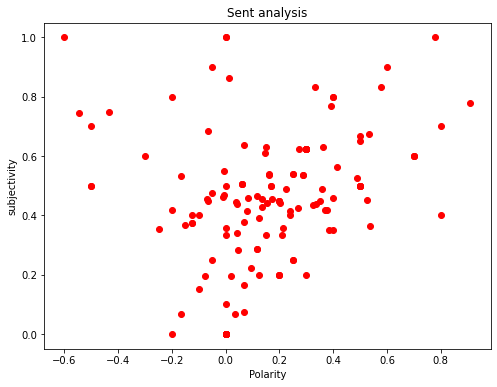

In [15]:
#The higher subjectivity means that the text contains personal opinion rather than factual information
#Higher polarity means more positive sentiment and vise-versa

plt.figure(figsize=(8,6))
for i in range(0, df.shape[0]):
    plt.scatter(df['polarity'][i], df['subjectivity'][i], color = 'red')
plt.title('Sentiment analysis')
plt.xlabel('Polarity')
plt.ylabel('subjectivity')
plt.show()